# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


#### **Function to create data frame**

In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [4]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Function to plot history of training**

**DATA READING**

In [5]:
data_dir = '/kaggle/input/plantvillage-dataset/color'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


#### **Display Image Sample**

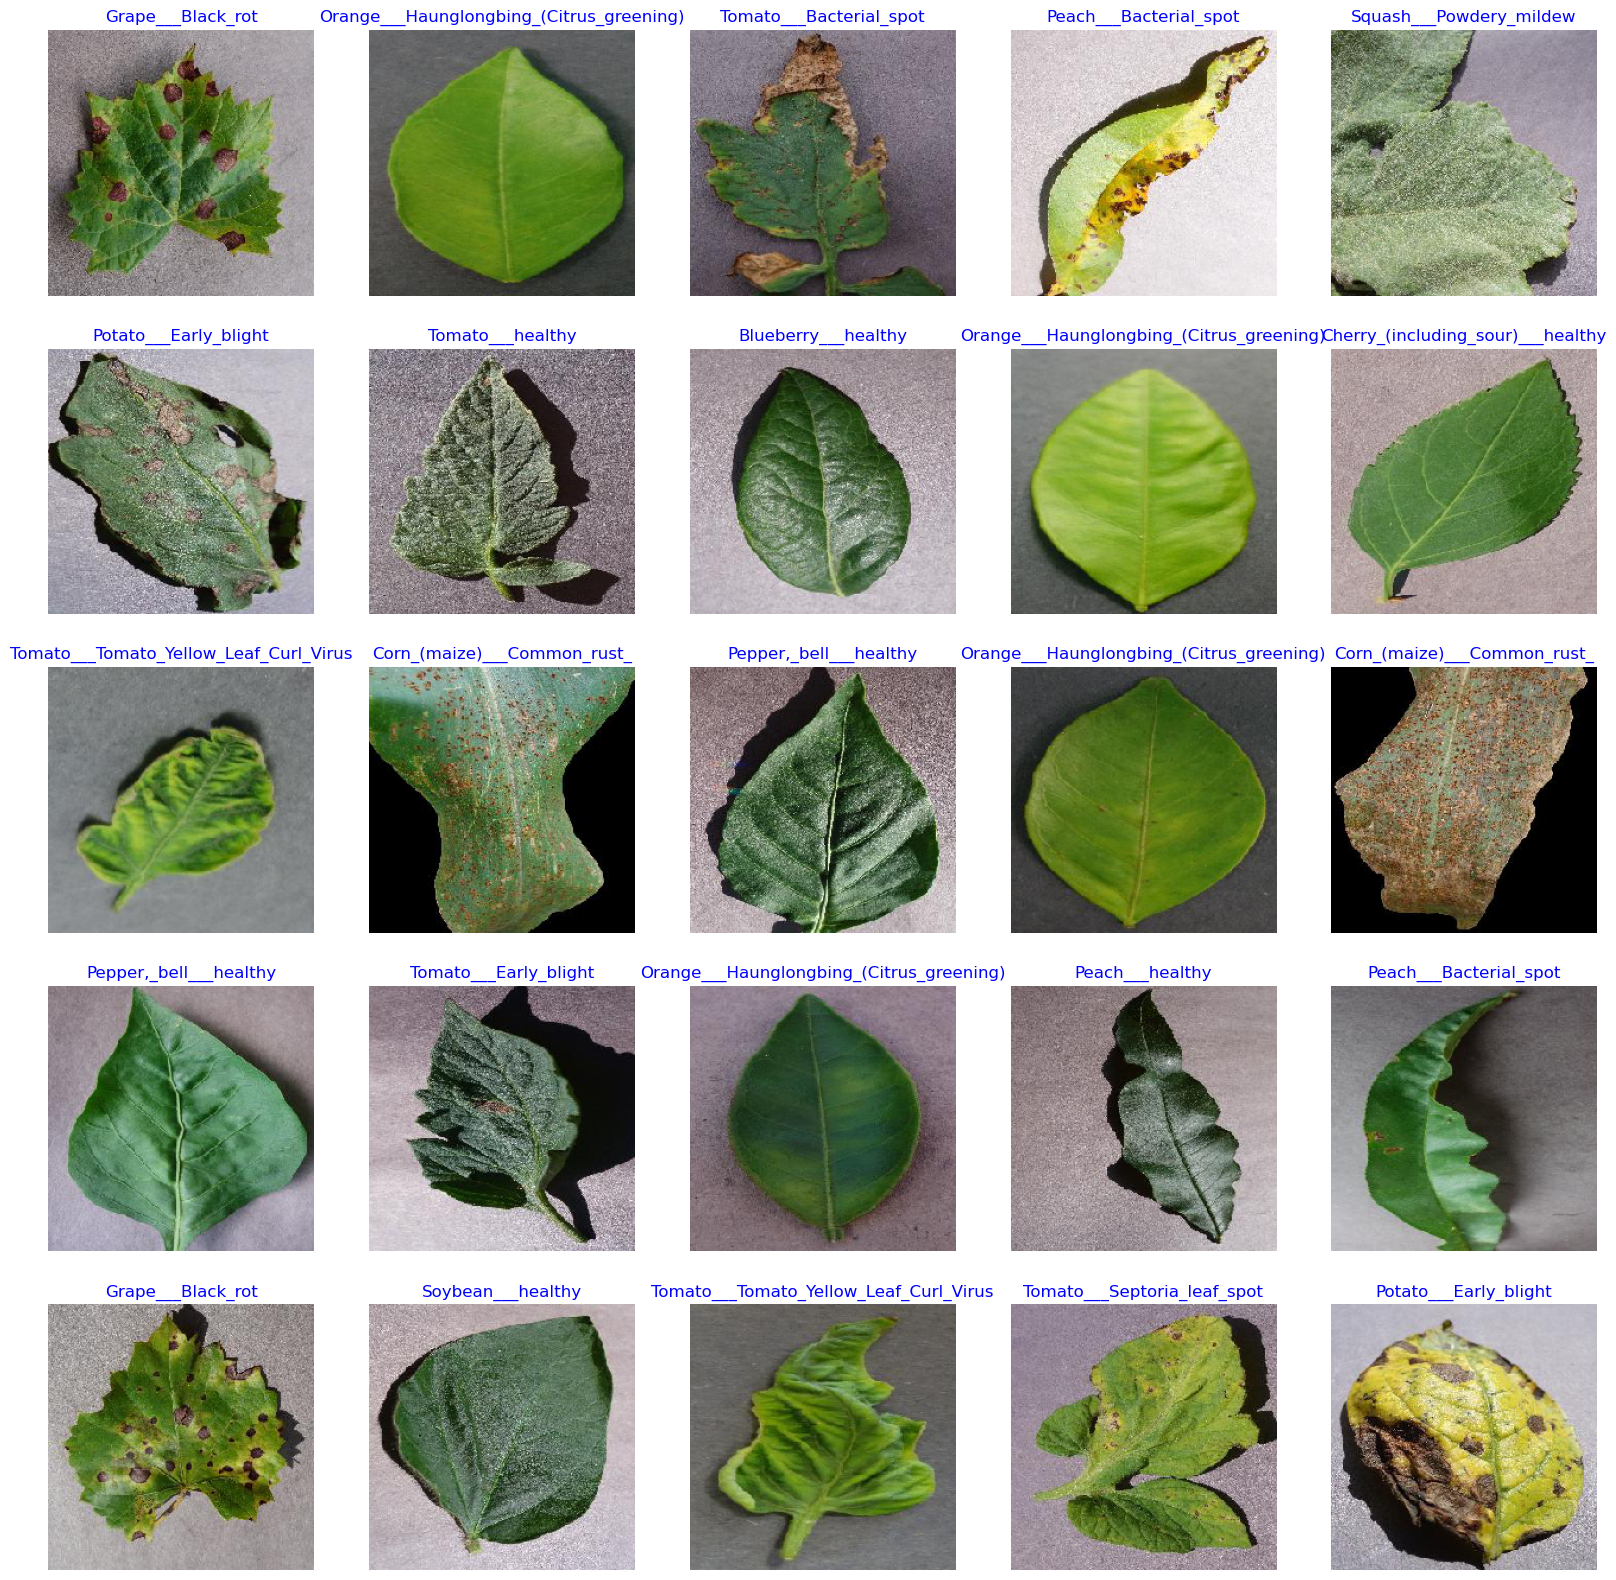

In [6]:
show_images(train_gen)

#### **Generic Model Creation**

In [7]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),    
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(loss='categorical_crossentropy',
             optimizer="adam",
             metrics=['accuracy'])

model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                         

#### **Train model**

In [8]:
callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
)

history = model.fit(x= train_gen ,epochs= 15, verbose= 1, callbacks= callbacks,
                    validation_data= valid_gen,validation_steps=None, shuffle= False)

Epoch 1/15


2023-04-02 02:32:22.461614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/mobilenet_1.00_224/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1087/1087 [==============================] - 271s 232ms/step - loss: 1.6791 - accuracy: 0.7159 - val_loss: 1.8206 - val_accuracy: 0.6727
Epoch 2/15
1087/1087 [==============================] - 222s 204ms/step - loss: 0.9216 - accuracy: 0.8148 - val_loss: 0.8751 - val_accuracy: 0.8134
Epoch 3/15
1087/1087 [==============================] - 236s 217ms/step - loss: 0.7600 - accuracy: 0.8400 - val_loss: 0.9193 - val_accuracy: 0.8101
Epoch 4/15
1087/1087 [==============================] - 223s 205ms/step - loss: 0.6973 - accuracy: 0.8489 - val_loss: 0.7676 - val_accuracy: 0.8444
Epoch 5/15
1087/1087 [==============================] - 223s 205ms/step - loss: 0.6324 - accuracy: 0.8572 - val_loss: 0.8423 - val_accuracy: 0.8295
Epoch 6/15
1087/1087 [==============================] - 224s 206ms/step - loss: 0.6089 - accuracy: 0.8604 - val_loss: 0.6684 - val_accuracy: 0.8484
Epoch 7/15
1087/1087 [==============================] - 221s 203ms/step - loss: 0.5430 - accuracy: 0.8710 - val_loss: 0.590

#### **Display model performance**

# **Evaluate model**

In [9]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5431/5431 [==============================] - 40s 7ms/step - loss: 0.7208 - accuracy: 0.8492
Train Loss:  0.7167801260948181
Train Accuracy:  0.8509575724601746
--------------------
Validation Loss:  0.7483406662940979
Validation Accuracy:  0.8441988825798035
--------------------
Test Loss:  0.7207992076873779
Test Accuracy:  0.8491990566253662


In [10]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

5431/5431 [==============================] - 30s 5ms/step
[15  3 24 ... 32 12 32]


#### **Confusion Matrics and Classification Report**

In [11]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.55      0.94      0.69        63
                                 Apple___Black_rot       1.00      0.50      0.67        62
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        27
                                   Apple___healthy       0.71      0.96      0.82       165
                               Blueberry___healthy       0.90      0.99      0.95       150
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       105
                 Cherry_(including_sour)___healthy       1.00      0.86      0.92        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        51
                       Corn_(maize)___Common_rust_       1.00      0.97      0.99       119
               Corn_(maize)___Northern_Leaf_Blight       0.50      0.01      0.

#### **Save model**

In [12]:
model_name = model.input_names[0][:-6]
subject = 'Plant Village Disease'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as mobilenet_1.00_224-Plant Village Disease-84.92.h5
weights were saved as mobilenet_1.00_224-Plant Village Disease-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [13]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Plant Village Disease-class_dict.csv


In [14]:

d="/kaggle/input/plantvillage-dataset/color/Tomato___healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG"
img=load_img(d)


im1=tf.image.resize(
    img,
    (224,224),
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=False,
    name=None
)

k=im1.numpy()
k=k.reshape(1,224,224,3)
mp=model.predict(k)
y_pred = np.argmax(mp, axis=1)


list(g_dict.keys())[y_pred[0]]

NameError: name 'load_img' is not defined

In [ ]:
print(g_dict)

In [ ]:
def pred_from_img(img1):
    img=load_img(img1)


    im1=tf.image.resize(
        img,
        (224,224),
        method=tf.image.ResizeMethod.BILINEAR,
        preserve_aspect_ratio=False,
        antialias=False,
        name=None
    )

    k=im1.numpy()
    k=k.reshape(1,224,224,3)
    mp=model.predict(k)
    y_pred = np.argmax(mp, axis=1)


    dis=list(g_dict.keys())[y_pred[0]]
    return dis;
    

In [ ]:
pred_from_img("/kaggle/input/plantvillage-dataset/color/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG")